# Install and load packages

In [1]:
!pip install -q transformers datasets wandb accelerate emoji kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 23.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 

In [2]:
import re, os
import kaleido
import torch, wandb
import transformers
import numpy as np
import emoji
import pandas as pd
from tqdm import tqdm
from datasets import Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer,TrainingArguments, AutoConfig, EarlyStoppingCallback, IntervalStrategy
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, classification_report, f1_score, precision_recall_fscore_support
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import numpy as np

import matplotlib.pyplot as plt



In [10]:
myproject = "oii-selftrain-eval"
nsample = 1 # 1 to run with the entire dataset
RANDOM_SEED = 88
preddatafolder = 'drive/MyDrive/bertimbau-selftrain/'

# Custom functions

In [ ]:
def set_random_seed(seed=RANDOM_SEED):
    """
    Function to set the random seed for numpy and PyTorch to ensure reproducibility.

    Parameters:
    seed (int): The seed value. Default is 42.

    Returns:
    None
    """

    # Set the seed for Numpy
    np.random.seed(seed)

    # Set the seed for PyTorch
    torch.manual_seed(seed)

    # If you're running on GPU, you also need to set the seed for the GPU:
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def prepare_test_dataset(test, cols, tokenize_function):
    """
    Function to prepare a test dataset.

    Parameters:
    test (DataFrame): The test DataFrame.
    cols (list): List of column names to include in the test DataFrame.
    tokenize_function (function): The function to tokenize the text data.

    Returns:
    Dataset: The prepared test dataset.
    """

    # Create a copy of the required columns
    test = test[cols].copy()

    # Convert 'text' column to string type
    test['text'] = test['text'].astype(str)

    # Convert the DataFrame to a Dataset
    test_dataset = Dataset.from_pandas(test)

    # Apply the tokenization function to the 'text' column
    test = test_dataset.map(tokenize_function, batched=True)

    return test


def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=TOKEN_MAX_LEN)

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Setup

In [ ]:
drive.mount('/content/drive')

tqdm.pandas(desc="Running...")

set_random_seed(42)

In [7]:
mydrive= 'drive/MyDrive/'
data_folder = mydrive + 'thesis-data/'
trainfile = data_folder + 'train/train.csv'
testfile = data_folder + 'test/test_label.csv'
testrawfile = data_folder + 'test/test_raw.csv'
unlabel_file = data_folder + 'train/unlabel.csv'


cols = ['text','label']

In [8]:
pretrainedmodel="<username>/oii-fc-v1"
bert_folder = mydrive + 'bert-exp/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

TOKEN_MAX_LEN = 128



cuda


# Prepare dataset

In [ ]:
test = pd.read_csv(testfile).sample(frac=nsample,random_state=RANDOM_SEED).set_index('id')
testraw = pd.read_csv(testrawfile).sample(frac=nsample,random_state=RANDOM_SEED).set_index('id')

print(test.shape)
print(testraw.shape)


(1211, 5)
(6724, 2)


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(pretrainedmodel,use_auth_token=hf_token)
model = AutoModelForSequenceClassification.from_pretrained(pretrainedmodel, num_labels=2,use_auth_token=hf_token)

# Run model

In [ ]:
def demojize(text):
    return emoji.demojize(text).replace(":"," ").replace("_"," ")

def replace_urls(text):
    # Regular expression to match URLs
    url_pattern = re.compile(
        r'(http[s]?://|www\.)'
        r'(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    )

    # Replace URLs with the tag #URL
    return url_pattern.sub('URL', text)


def explode_dict(df, columns):
    for col in columns:
        df = pd.concat(
            [df.drop(col, axis=1), df[col].apply(pd.Series)], axis=1)
    return df

def cleantxt(text, lower=False):
    text = str(text)

    if lower:
        text = text.lower() # convert to lowercase
    text = replace_urls(text) # replace urls by token
    text = re.sub(r'\s+', ' ', text) # trim extra spaces
    text = re.sub(r'@\w+', 'USR', text) # remove user handles by token
    text = re.sub(r'(.)\1{3,}', r'\1\1\1\1', text) # remove repetition of char
    text = re.sub(r'[^\w\s]', ' ', text) # remove commas and other punctuation

    text = demojize(text)

    return text

In [ ]:
def get_predicted_class(text):
    text = cleantxt(text)
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)

    # Softmax function to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # The predicted class is the one with the maximum probability
    pred_class = torch.argmax(probabilities).item()

    # Get the probabilities for each class
    probab_0 = probabilities[0][0].item()
    probab_1 = probabilities[0][1].item()

    return [pred_class, probab_0, probab_1]

# get_predicted_class(test.iloc[1]['text'])
# Apply the modified function to the test dataset
# test['pred_label'] = test['text'].progress_apply(get_predicted_class)[0]
# test['probab_0'] = test['text'].progress_apply(get_predicted_class)[1]
# test['probab_1'] = test['text'].progress_apply(get_predicted_class)[2]

test[['pred_label', 'probab_0', 'probab_1']] = test['text'].progress_apply(get_predicted_class).apply(pd.Series)

Running...: 100%|██████████| 1211/1211 [11:09<00:00,  1.81it/s]


In [ ]:
testraw[['pred_label', 'probab_0', 'probab_1']] = testraw['text'].progress_apply(get_predicted_class).apply(pd.Series)

Running...: 100%|██████████| 6724/6724 [59:31<00:00,  1.88it/s]


In [ ]:
# testraw['pred_label'] = testraw['text'].progress_apply(get_predicted_class)

# Read dataset

In [11]:
pred_replies = preddatafolder + 'pred_replies.csv'
pred_reports = preddatafolder + 'pred_reports.csv'

testraw = pd.read_csv(pred_replies)

test = pd.read_csv(pred_reports)


# Evaluation function

In [12]:
def print_metrics(df):
    # Extract labels and predicted labels from the dataframe
    labels = df['label']
    pred_labels = df['pred_label']

    # Calculate confusion matrix
    cm = confusion_matrix(labels, pred_labels)
    print(cm)
    classes = sorted(list(set(labels) | set(pred_labels)))

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, pred_labels)
    auc_score = roc_auc_score(labels, pred_labels)

    # Calculate classification report
    report = classification_report(labels, pred_labels, output_dict=True)
    macro_avg_f1 = report['macro avg']['f1-score']
    recall = report['weighted avg']['recall']
    precision = recall = report['weighted avg']['precision']
    accuracy = report['accuracy']
    positive_recall = report[str(classes[1])]['recall']

    # Print metrics as text
    print(report)
    print('--')
    print(f"F1 Macro-Average: {macro_avg_f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Recall (Positive Class): {positive_recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")


print_metrics(testraw)


[[4118  697]
 [ 180 1729]]
{'0': {'precision': 0.9581200558399255, 'recall': 0.8552440290758048, 'f1-score': 0.9037638538351804, 'support': 4815}, '1': {'precision': 0.7126957955482275, 'recall': 0.9057097957045573, 'f1-score': 0.7976931949250288, 'support': 1909}, 'accuracy': 0.8695716835217132, 'macro avg': {'precision': 0.8354079256940765, 'recall': 0.880476912390181, 'f1-score': 0.8507285243801046, 'support': 6724}, 'weighted avg': {'precision': 0.8884420497577048, 'recall': 0.8695716835217132, 'f1-score': 0.8736495040642881, 'support': 6724}}
--
F1 Macro-Average: 0.8507
Recall: 0.8884
Recall (Positive Class): 0.9057
Accuracy: 0.8696
Precision: 0.8884


In [ ]:
print_metrics(test)

[[705  28]
 [ 61 417]]
{'0': {'precision': 0.9203655352480418, 'recall': 0.9618008185538881, 'f1-score': 0.9406270847231488, 'support': 733}, '1': {'precision': 0.9370786516853933, 'recall': 0.8723849372384938, 'f1-score': 0.903575297941495, 'support': 478}, 'accuracy': 0.9265070189925682, 'macro avg': {'precision': 0.9287220934667175, 'recall': 0.9170928778961909, 'f1-score': 0.9221011913323219, 'support': 1211}, 'weighted avg': {'precision': 0.9269624548657577, 'recall': 0.9265070189925682, 'f1-score': 0.926002184573165, 'support': 1211}}
--
F1 Macro-Average: 0.9221
Recall: 0.9270
Recall (Positive Class): 0.8724
Accuracy: 0.9265
Precision: 0.9270


# Plot

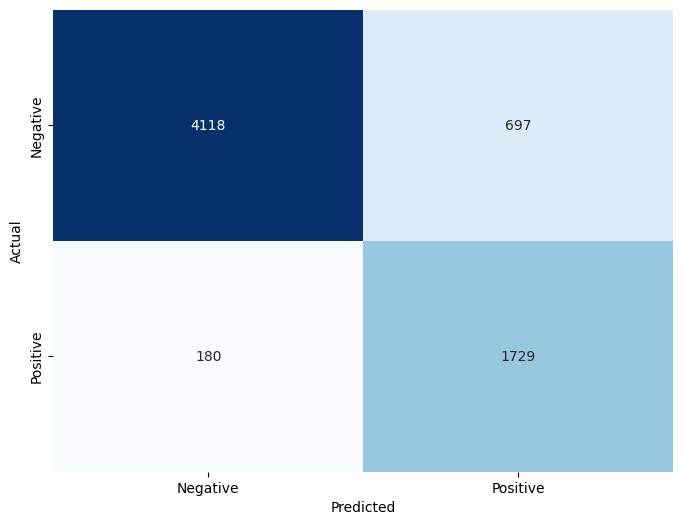

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, pred_probabilities, class_names):
    cm = confusion_matrix(labels, pred_probabilities.round())

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

# Then call the function
plot_cm(testraw['label'], testraw['probab_1'], ['Negative', 'Positive'])


In [39]:

def plot_cf_roc(df, font_size=20):
    # Extract labels, predicted probabilities for class 1, and ground truth probabilities for class 1 from the dataframe
    labels = df['label']
    pred_probabilities = df['probab_1']

    # Calculate confusion matrix
    cm = confusion_matrix(labels, pred_probabilities.round())
    print(cm)
    cm_totals = cm.sum(axis=1)
    cm_percentages = np.round(cm / cm_totals[:, np.newaxis] * 100, decimals=2)
    print(cm_percentages)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, pred_probabilities)
    roc_auc = auc(fpr, tpr)

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('a) Confusion Matrix', 'b) ROC Curve'))
    fig['layout']['annotations'][0]['font'] = dict(size=font_size)  # adjust size as needed for the confusion matrix
    fig['layout']['annotations'][1]['font'] = dict(size=font_size)  # adjust si

    # Plot confusion matrix
    fig.add_trace(go.Heatmap(
        z=np.flip(cm, 0),
        x=['Negative', 'Positive'],
        y=['Positive', 'Negative'],
        colorscale='Blues',
        showscale=False
    ), row=1, col=1)

    # Modify annotations accordingly
    for i in range(len(cm_percentages)):
        for j in range(len(cm_percentages[i])):
            fig.add_annotation(
                x=j, y=(len(cm_percentages)-1-i),
                text=f'<b>{cm[i, j]}</b><br>({cm_percentages[i, j]}%)',
                showarrow=False,
                font=dict(color='#fff' if cm_percentages[i, j] > 50 else 'black', size=14),
                xref='x1', yref='y1'
            )

    # Plot ROC curve
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        line=dict(color='darkorange', width=2),
        name=f'ROC curve (AUC = {roc_auc:.2f})'
    ), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        line=dict(color='navy', width=2, dash='dash'),
        name='Random baseline'
    ), row=1, col=2)

    # Add legend to the ROC curve subplot
    fig.update_layout(
        legend=dict(
            x=0.7,
            y=0.1,
            traceorder="normal",
            bgcolor="rgba(0,0,0,0)",
            bordercolor="rgba(0,0,0,0)"
        )
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')

    # Update layout
    fig.update_layout(
        template='presentation',
        width=1000,
        height=500,
        showlegend=True,
        title_font_size=20
    )

    fig.update_xaxes(title_text='Predicted class', title_font=dict(size=14), row=1, col=1)
    fig.update_yaxes(title_text='Actual class', title_font=dict(size=14), row=1, col=1)
    fig.update_xaxes(title_text='False Positive Rate', title_font=dict(size=14), row=1, col=2)
    fig.update_yaxes(title_text='True Positive Rate', title_font=dict(size=14), row=1, col=2)


    fig.update_xaxes(showline=True,
         linewidth=1,
         linecolor='black',
         mirror=True)

    fig.update_yaxes(showline=True,
         linewidth=1,
         linecolor='black',
         zeroline=False,
         mirror=True)

    # Display the plot
    return fig

plot_cf_roc(test).show()
plot_cf_roc(test).write_image("test_reports.png", width=1000, height=600, scale=2)

[[705  28]
 [ 61 417]]
[[96.18  3.82]
 [12.76 87.24]]


[[705  28]
 [ 61 417]]
[[96.18  3.82]
 [12.76 87.24]]


In [40]:
plot_cf_roc(testraw).show()
plot_cf_roc(testraw).write_image("test_replies.png", width=1000, height=600, scale=2)

[[4118  697]
 [ 180 1729]]
[[85.52 14.48]
 [ 9.43 90.57]]


[[4118  697]
 [ 180 1729]]
[[85.52 14.48]
 [ 9.43 90.57]]


In [ ]:

pred_replies = datafolder + 'pred_replies.csv'
pred_reports = datafolder + 'pred_reports.csv'
test.to_csv(pred_reports)
testraw.to_csv(pred_replies)